# **Automated Glaucoma Screening Using Optic Disc-Cup Segmentation and Hybrid Machine Learning Model**

### Data Aqusitions and Paths.

First let's download the Glaucoma datasets from kaggle using kagglehub.

In [299]:
import kagglehub
from pathlib import Path


dataset_info = kagglehub.dataset_download("arnavjain1/glaucoma-datasets")

#Handle kagglehub returning tuple or string
if isinstance(dataset_info, tuple):
    path = dataset_info[0]
else:
    path = dataset_info

ROOT = Path(path)

print("Dataset root:", ROOT)
print("ROOT exists:", ROOT.exists())
print("Top-level folders:", [p.name for p in ROOT.iterdir() if p.is_dir()])

Using Colab cache for faster access to the 'glaucoma-datasets' dataset.
Dataset root: /kaggle/input/glaucoma-datasets
ROOT exists: True
Top-level folders: ['models', 'REFUGE', 'ORIGA', 'G1020']


In the below code cell, we import the necessary libraries to build our model. By setting the TARGET_SIZE to 512, all images and masks are standadized to a common resolution and it is a key hyperparameter. Then dataset folder names and image subfolders are defined.

In [234]:
##%load_ext cudf.pandas        #if use the GPU uncomment this line
##%load_ext cuml.accel

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

ROOT = Path(path)
TARGET_SIZE = 512

datasets = ["G1020" ,"ORIGA" , "REFUGE"]    #dataset folder name

### Label tables(classification metadata)

Now, let's create an unified classification table containing image file paths and glaucoma labels. For that we read dataset metadata from CSV and JSON files. For G1020 and ORIGA datasets, labels are loaded from CSV files and for REFUGE dataset, labels come from index.json in the train and validation splits.

The below code constructs a dataframe which includes absolute image paths for each datasets. Also labels are cleaned and converted into 1 or 0 values to standardize the label format across datasets.

The purpose of creating such dataframe is using an unified label table helps document dataset labels and supports class distribution analysis.

In [235]:
g_df = pd.read_csv(ROOT / datasets[0] / "G1020.csv")
o_df = pd.read_csv(ROOT / datasets[1] / "OrigaList.csv")
r_train_pd = pd.read_json(ROOT / datasets[2] / "train/index.json", orient="index")
r_val_pd   = pd.read_json(ROOT / datasets[2] / "val/index.json", orient="index")

#set your actual image folders
g_img_dir = ROOT / datasets[0] / "Images_Square"
o_img_dir = ROOT / datasets[1] / "Images_Square"

r_train_img_dir = ROOT / datasets[2] / "train" / "Images"
r_val_img_dir   = ROOT / datasets[2] / "val"   / "Images"

#build full paths per dataset
g_small = pd.DataFrame({
    "img_path": g_df["imageID"].astype(str).map(lambda f: str(g_img_dir / f)),
    "glaucoma": g_df["binaryLabels"]
})

o_small = pd.DataFrame({
    "img_path": o_df["Filename"].astype(str).map(lambda f: str(o_img_dir / f)),
    "glaucoma": o_df["Glaucoma"]
})

r_train_small = pd.DataFrame({
    "img_path": r_train_pd["ImgName"].astype(str).map(lambda f: str(r_train_img_dir / f)),
    "glaucoma": r_train_pd["Label"]
})

r_val_small = pd.DataFrame({
    "img_path": r_val_pd["ImgName"].astype(str).map(lambda f: str(r_val_img_dir / f)),
    "glaucoma": r_val_pd["Label"]
})

#stack all rows into one dataframe
df = pd.concat([g_small, o_small, r_train_small, r_val_small], ignore_index=True)

#clean label to int 0/1
df["glaucoma"] = pd.to_numeric(df["glaucoma"], errors="coerce").fillna(0).astype(int)


Mask paths are generated from image paths by replacing `Images_Square` with `Masks_Square`, `Images` with `Masks`, and changing the file extension from `.jpg` to `.png`. This transformation is applied to all image paths using a helper function and Pandas `.apply()` for clean and consistent mapping.


In [236]:
def image_to_mask_path(path):
    return (
        path
        .replace("Images_Square", "Masks_Square")
        .replace("Images", "Masks")
        .replace(".jpg", ".png")
    )

df["mask_path"] = df["img_path"].apply(image_to_mask_path)

In [237]:
df.head()

,img_path,glaucoma,mask_path
0,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
1,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
2,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
3,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
4,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...


### Pairing and Splitting Data

Let's pair images with their masks. In order to do that we define a helper function which creates valid image path and mask path pairs.

The reason for this is segmentation requires exact pixel aligned ground truth masks. So explicit pairing step is critical here.

This pairing is done by checking for a mask with the same filename and a .png extension. Also this function returns how many image-mask pairs were found to confirm dataset integrity.

In [238]:
#get the paire of image and mask

def listPairs(df) -> list:
  pairs = df[["img_path" ,"mask_path"]]

  print(f"Found {len(pairs)} ")
  return pairs.values.tolist()


So let's load training and validation pairs in REFUGE dataset folder using the above helper function.

After that we tried to pair testing images and masks in a try except block to prevent program crashes if the dataset package does not include a usable test folder.



Here we define a function called splitPairs which splits image mask pairs into train or validation or test subsets using train_test_split with a fixed random seed. The strategy used is 70% training and 30% temporary split, then dividing the temporary split equally into validation and test (15%/15%).

Using a fixed seed ensures the split is reproducible enabling consistent results across runs.

In [239]:
#6
def splitPairs(df, seed = 42):
    train, tmp = train_test_split(df, test_size=0.30, random_state=seed, shuffle=True)
    val, test  = train_test_split(tmp, test_size=0.50, random_state=seed, shuffle=True)
    return train, val, test

In [240]:
train_df , val_df , test_df = splitPairs(df)

train_df.groupby("glaucoma").count() , val_df.groupby("glaucoma").count() , test_df.groupby("glaucoma").count()

(          img_path  mask_path
 glaucoma                     
 0             1362       1362
 1              367        367,
           img_path  mask_path
 glaucoma                     
 0              290        290
 1               80         80,
           img_path  mask_path
 glaucoma                     
 0              274        274
 1               97         97)

convert data frame to split lists

In [241]:
train_pairs = listPairs(train_df)
val_pairs  = listPairs(val_df)
test_pairs = listPairs(test_df)

Found 1729 
Found 370 
Found 371 


In [242]:
def compute_pos_weight(y_train):
    y_train = np.asarray(y_train).astype(int)
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    return torch.tensor([neg / max(pos, 1)], dtype=torch.float32)

### Segmentation dataset, Loaders and Visualization.

Now we are going to define the ODSegDataset class which loads an image and its mask and converts them into tensors suitable for training a segmentation network.

Images are resized to TARGET_SIZE, normalized to [0,1] and converted to channel-first PyTorch tensors (3,H,W). Here, masks are resized using nearest-neighbor interpolation to preserve discrete class values and after that converted into two binary channels named optic disc(mask==1) and optic cup(maks==2). Splitting disc/cup into two channels directly supports multi-class segmentation in UNet.

The dataset returns image tensor, mask tensor and image path to support both training and debugging.

In [243]:
class ODSegDataset(Dataset):
  def __init__(self, pairs , targetSize = 512) -> None:
    self.pairs = pairs
    self.targetSize = targetSize

  def __len__(self) ->int:
    return len(self.pairs)

  def __getitem__(self, index):
      imgPath , maskPath = self.pairs[index]

      img = Image.open(imgPath).convert("RGB")
      img = img.resize((self.targetSize, self.targetSize), resample=Image.BILINEAR)
      img = np.array(img).astype(np.float32) / 255.0
      img = torch.from_numpy(img).permute(2,0,1)  #(3,H,W)


      mask = Image.open(maskPath).convert("L")
      mask = mask.resize((self.targetSize, self.targetSize), resample=Image.NEAREST)
      mask = np.array(mask).astype(np.uint8)

      disc = (mask == 1).astype(np.float32)
      cup = (mask == 2).astype(np.float32)

      y = torch.from_numpy(np.stack([disc , cup], axis= 0))

      return img, y , str(imgPath)


Below we create PyTorch DataLoaders for train, val, test datasets with appropriate settings. Training data is shuffled to improve learning and reduce ordering bias while validation and test loaders are not shuffled for stable evaluation. Batch size and num_workers are controlled through function parameters and loaders are created for each dataset as well as later for the combined dataset. DataLoaders handle batching and efficient loading. Separating shuffle behavior is best practice for fair evaluation.

In [244]:
def make_loaders(train_pairs, val_pairs, test_pairs, batch=4, num_workers=2):
    train_ds = ODSegDataset(train_pairs, TARGET_SIZE)
    val_ds   = ODSegDataset(val_pairs, TARGET_SIZE)
    test_ds  = ODSegDataset(test_pairs, TARGET_SIZE)

    trainLoader = DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=num_workers)
    valLoader   = DataLoader(val_ds, batch_size=batch, shuffle=False, num_workers=num_workers)
    testLoader  = DataLoader(test_ds, batch_size=batch, shuffle=False, num_workers=num_workers)

    return trainLoader, valLoader, testLoader



Let's do a sanity check for batch shapes and mask channels. Images have shape (B,3,512,512) and masks have shape (B,2,512,512). This code block also prints summed mask values for disc and cup to ensure masks are not empty. This is an early validation step that confirms the data pipeline is functioning correctly.

In [245]:
train_loader, val_loader, test_loader = make_loaders(train_pairs, val_pairs, test_pairs, batch=4, num_workers=2)

print("Combined train:", len(train_pairs), "val:", len(val_pairs), "test:", len(test_pairs))


Combined train: 1729 val: 370 test: 371


The below cell visualizes a sample from each dataset loader:

*   The RGB Fundus Image
*   The Optic Disc Mask
*   The Optic Cup Mask

This qualitative inspection confirms that masks are aligned with the fundus image and that disc/cup segmentation labels are interpreted correctly.

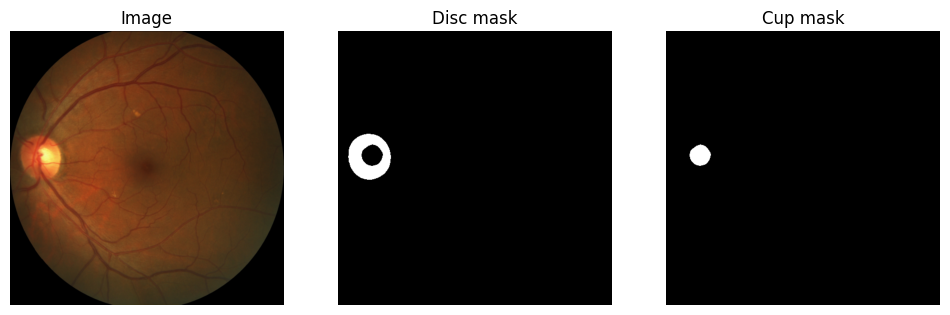

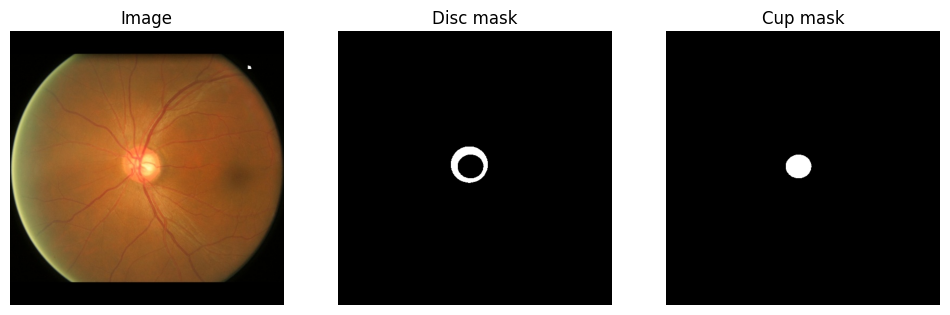

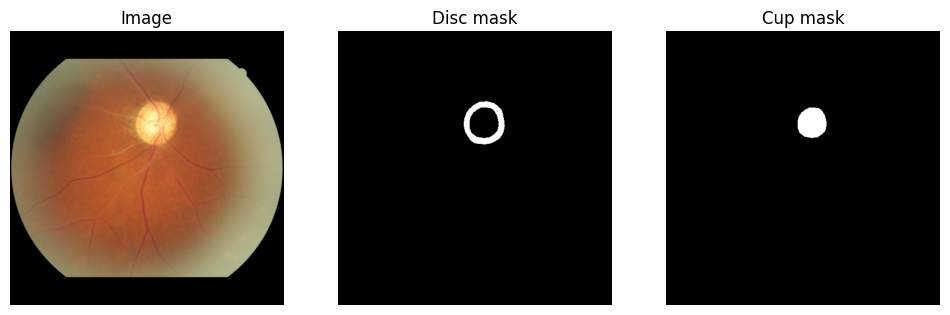

In [246]:
import matplotlib.pyplot as plt

def show_batch(loader):
    x, y, path = next(iter(loader))
    img = x[0].permute(1,2,0).numpy()  #HWC
    disc = y[0,0].numpy()
    cup  = y[0,1].numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Disc mask"); plt.imshow(disc, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Cup mask");  plt.imshow(cup, cmap="gray");  plt.axis("off")
    plt.show()

show_batch(train_loader)
show_batch(val_loader)
show_batch(test_loader)

### Model, Losses, Training Loop and Checkpointing

First, we are going to install segmentation-models-pytorch and timm which provide tested implementations of popular segmentation architectures and pretrained encoders.

Then we initialize a UNet segmentation model with a ResNet34 encoder using ImageNet pretrained weights. UNet is widely used for biomedical segmentation due to skip connections preserving spatial detail.

The model is configured for 3 channel RGB input and outputs 2 segmentation channels corresponding to optic disc and optic cup. The model is moved to GPU if available for faster training. This setup adapts a strong general purpose visual feature extractor to the medical segmentation task by replacing the segmentation head to predict disc/cup masks.

In [247]:
!pip -q install segmentation-models-pytorch timm

In [248]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [249]:
import segmentation_models_pytorch as smp

seg_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
    activation=None
).to(device)


As the next step we define the training objective used for segmentation. BCEWithLogitsLoss provides stable pixel wise classification directly from logits, while Dice loss measures overlap quality and is particularly helpful when foreground regions (disc/cup) are much smaller than background.

Dice is widely used in medical segmentation to handle class imbalance and better reflect segmentation quality than accuracy alone.

The combined loss (BCE + Dice) balances pixel level correctness and region level overlap improving segmentation quality for both disc and cup.

In [250]:
import torch.nn as nn
import torch.nn.functional as F

@torch.no_grad()
def dice_per_channel_from_logits(logits, target, thr=0.5, eps=1e-6):
    prob = torch.sigmoid(logits)
    disc = (prob[:,0] >= thr).float()
    cup  = (prob[:,1] >= thr).float()

    # enforce cup inside disc (out-of-place)
    cup = cup * disc

    pred = torch.stack([disc, cup], dim=1)  # (B,2,H,W)

    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)  # (B,2)
    disc_dice = dice[:,0].mean().item()
    cup_dice  = dice[:,1].mean().item()
    mean_dice = dice.mean().item()
    return mean_dice, disc_dice, cup_dice


@torch.no_grad()
def estimate_pos_weight(train_loader, device, max_batches=50):
    pos = torch.zeros(2, device=device)
    tot = torch.zeros(2, device=device)

    for i, (_, y, _) in enumerate(train_loader):
        y = y.to(device)  # (B,2,H,W)
        pos += y.sum(dim=(0,2,3))
        tot += torch.tensor([y[:,0].numel(), y[:,1].numel()], device=device)

        if i+1 >= max_batches:
            break

    neg = tot - pos
    pw = neg / (pos + 1e-9)   #(2,)
    return pw.detach()


def weighted_bce_from_logits(logits, target, pos_weight, w_disc=1.0, w_cup=2.0):
    #logits/target: (B,2,H,W)
    bce_disc = F.binary_cross_entropy_with_logits(
        logits[:,0], target[:,0], pos_weight=pos_weight[0]
    )
    bce_cup = F.binary_cross_entropy_with_logits(
        logits[:,1], target[:,1], pos_weight=pos_weight[1]
    )
    return w_disc*bce_disc + w_cup*bce_cup

def soft_dice_loss_from_probs(prob, target, eps=1e-6, w_disc=1.0, w_cup=2.0):
    #prob/target: (B,2,H,W), prob in [0,1]
    inter = (prob * target).sum(dim=(2,3))
    union = prob.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)   #(B,2)
    dice = dice.mean(dim=0)                  #(2,)
    loss_disc = 1 - dice[0]
    loss_cup  = 1 - dice[1]
    return w_disc*loss_disc + w_cup*loss_cup

def total_loss(logits, target, pos_weight, w_disc=1.0, w_cup=2.5, lam_bce=1.0, lam_dice=1.0):
    #logits: (B,2,H,W)
    prob = torch.sigmoid(logits)

    #enforce cup inside disc OUT-OF-PLACE
    disc_prob = prob[:,0]
    cup_prob  = prob[:,1] * disc_prob
    prob2 = torch.stack([disc_prob, cup_prob], dim=1)

    bce  = weighted_bce_from_logits(logits, target, pos_weight, w_disc=w_disc, w_cup=w_cup)
    dice = soft_dice_loss_from_probs(prob2, target, w_disc=w_disc, w_cup=w_cup)
    return lam_bce*bce + lam_dice*dice


Let's implement Explicit training loop with forward pass, loss, backprop and optimizer update.

For each batch, the model performs a forward pass to produce logits, computes the combined loss and during training, performs backpropagation (loss.backward()) and an optimizer update (optimizer.step()).

Validation is performed with model.eval() and gradient disabling to ensure evaluation does not update weights. The code logs loss and Dice each epoch, tracks best validation Dice, and saves the best model checkpoint.


In [251]:
from tqdm import tqdm

#estimate pos_weight from training masks
pos_weight = estimate_pos_weight(train_loader, device=device, max_batches=50)
print("pos_weight (disc,cup):", pos_weight.detach().cpu().numpy())

optimizer = torch.optim.AdamW(seg_model.parameters(), lr=1e-3, weight_decay=1e-4)

use_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

def run_one_epoch(loader, training=True, thr_metric=0.5):
    seg_model.train() if training else seg_model.eval()

    total = 0.0
    mean_d, disc_d, cup_d = 0.0, 0.0, 0.0
    n = 0

    for x, y, _ in tqdm(loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        with torch.set_grad_enabled(training):
            if use_amp:
                with torch.amp.autocast("cuda", enabled=True):
                    logits = seg_model(x)
                    loss = total_loss(logits, y, pos_weight=pos_weight,
                                      w_disc=1.0, w_cup=2.5, lam_bce=1.0, lam_dice=1.0)
            else:
                logits = seg_model(x)
                loss = total_loss(logits, y, pos_weight=pos_weight,
                                  w_disc=1.0, w_cup=2.5, lam_bce=1.0, lam_dice=1.0)

            if training:
                optimizer.zero_grad(set_to_none=True)
                if use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

        bs = x.size(0)
        total += loss.item() * bs
        n += bs

        md, dd, cd = dice_per_channel_from_logits(logits, y, thr=thr_metric)
        mean_d += md * bs
        disc_d += dd * bs
        cup_d  += cd * bs

    return total/n, mean_d/n, disc_d/n, cup_d/n



pos_weight (disc,cup): [ 82.118195 238.5475  ]


In [252]:
best_cup = -1
save_path = "best_unet_resnet34.pth"

EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_md, tr_dd, tr_cd = run_one_epoch(train_loader, training=True)
    va_loss, va_md, va_dd, va_cd = run_one_epoch(val_loader, training=False)

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} dice(mean/disc/cup) {tr_md:.4f}/{tr_dd:.4f}/{tr_cd:.4f} | "
          f"val loss {va_loss:.4f} dice(mean/disc/cup) {va_md:.4f}/{va_dd:.4f}/{va_cd:.4f}")

    #save best by CUP dice (best for vCDR)
    if va_cd > best_cup:
        best_cup = va_cd
        torch.save(seg_model.state_dict(), save_path)
        print("saved best (by val cup dice)")

Epoch 01 | train loss 2.9411 dice(mean/disc/cup) 0.4554/0.5216/0.3892 | val loss 2.2445 dice(mean/disc/cup) 0.5219/0.5779/0.4659
saved best (by val cup dice)


Epoch 02 | train loss 2.3405 dice(mean/disc/cup) 0.5295/0.5981/0.4610 | val loss 2.2017 dice(mean/disc/cup) 0.5490/0.6209/0.4771
saved best (by val cup dice)


Epoch 03 | train loss 1.9308 dice(mean/disc/cup) 0.6080/0.6677/0.5484 | val loss 2.0454 dice(mean/disc/cup) 0.7083/0.7198/0.6969
saved best (by val cup dice)


Epoch 04 | train loss 1.8705 dice(mean/disc/cup) 0.6171/0.6767/0.5575 | val loss 1.7807 dice(mean/disc/cup) 0.6528/0.7002/0.6053


Epoch 05 | train loss 1.6720 dice(mean/disc/cup) 0.6520/0.7074/0.5967 | val loss 1.6751 dice(mean/disc/cup) 0.6352/0.6984/0.5719


Epoch 06 | train loss 1.5984 dice(mean/disc/cup) 0.6678/0.7180/0.6175 | val loss 1.8962 dice(mean/disc/cup) 0.6195/0.7014/0.5376


Epoch 07 | train loss 1.5980 dice(mean/disc/cup) 0.6695/0.7204/0.6186 | val loss 1.5844 dice(mean/disc/cup) 0.6544/0.7190/0.5898


Epoch 08 | train loss 1.4653 dice(mean/disc/cup) 0.6895/0.7329/0.6460 | val loss 1.6880 dice(mean/disc/cup) 0.6926/0.6990/0.6862


Epoch 09 | train loss 1.4983 dice(mean/disc/cup) 0.6891/0.7312/0.6470 | val loss 1.4833 dice(mean/disc/cup) 0.7133/0.7275/0.6992
saved best (by val cup dice)


Epoch 10 | train loss 1.3850 dice(mean/disc/cup) 0.7065/0.7446/0.6683 | val loss 1.6974 dice(mean/disc/cup) 0.6399/0.7104/0.5694


Epoch 11 | train loss 1.3666 dice(mean/disc/cup) 0.7097/0.7458/0.6735 | val loss 1.5648 dice(mean/disc/cup) 0.6507/0.7162/0.5853


Epoch 12 | train loss 1.3814 dice(mean/disc/cup) 0.7079/0.7411/0.6747 | val loss 1.4663 dice(mean/disc/cup) 0.6954/0.7340/0.6569


Epoch 13 | train loss 1.3632 dice(mean/disc/cup) 0.7102/0.7434/0.6770 | val loss 1.4339 dice(mean/disc/cup) 0.7177/0.7467/0.6887


Epoch 14 | train loss 1.3101 dice(mean/disc/cup) 0.7220/0.7522/0.6919 | val loss 1.4661 dice(mean/disc/cup) 0.7113/0.7465/0.6762


Epoch 15 | train loss 1.3105 dice(mean/disc/cup) 0.7180/0.7484/0.6877 | val loss 1.4441 dice(mean/disc/cup) 0.7306/0.7433/0.7179
saved best (by val cup dice)


Epoch 16 | train loss 1.3398 dice(mean/disc/cup) 0.7135/0.7411/0.6860 | val loss 1.6218 dice(mean/disc/cup) 0.7303/0.7395/0.7211
saved best (by val cup dice)


Epoch 17 | train loss 1.3121 dice(mean/disc/cup) 0.7182/0.7438/0.6926 | val loss 1.4448 dice(mean/disc/cup) 0.7338/0.7498/0.7178


Epoch 18 | train loss 1.2540 dice(mean/disc/cup) 0.7285/0.7568/0.7002 | val loss 1.5189 dice(mean/disc/cup) 0.7313/0.7472/0.7153


Epoch 19 | train loss 1.2009 dice(mean/disc/cup) 0.7358/0.7593/0.7122 | val loss 1.5404 dice(mean/disc/cup) 0.7594/0.7651/0.7536
saved best (by val cup dice)


Epoch 20 | train loss 1.1787 dice(mean/disc/cup) 0.7403/0.7623/0.7183 | val loss 1.5515 dice(mean/disc/cup) 0.7583/0.7658/0.7508


In [253]:
seg_model.load_state_dict(torch.load("best_unet_resnet34.pth", map_location=device))
test_loss, test_mean_dice, test_disc_dice, test_cup_dice = run_one_epoch(test_loader, training=False)
print("=== Test ===")
print(f"loss: {test_loss:.4f}, dice(mean/disc/cup): {test_mean_dice:.4f}/{test_disc_dice:.4f}/{test_cup_dice:.4f}")


=== Test ===
loss: 1.3556, dice(mean/disc/cup): 0.7569/0.7660/0.7477


### Post Processing and VCDR extraction.

Here we define an inference function that preprocesses a fundus image, runs the segmentation model and converts predicted probability maps into binary disc and cup masks using a threshold. To enforce anatomical plausibility, it constrains the cup mask to lie inside the disc mask.

It then computes vertical diameters and the Vertical Cup-to-Disc Ratio (VCDR), along with disc/cup areas.

---

VCDR is clinically relevant because increased cup-to-disc ratio is commonly associated with glaucomatous optic neuropathy, making this feature meaningful for glaucoma related downstream analysis.

In [254]:
import torch


def preprocess_image(img_path, size=512):
    img = Image.open(img_path).convert("RGB").resize((size,size))
    x = np.array(img).astype(np.float32)/255.0
    x = torch.from_numpy(x).permute(2,0,1).unsqueeze(0)  #(1,3,H,W)
    return x

def vertical_diameter(mask_2d: np.ndarray) -> float:
    rows = np.where(mask_2d.sum(axis=1) > 0)[0]
    if len(rows) == 0:
        return 0.0
    return float(rows[-1] - rows[0] + 1)

@torch.no_grad()
def predict_vcdr(model, img_path, thr=0.5, size=512):
    model.eval()
    x = preprocess_image(img_path, size=size).to(device)

    with torch.no_grad():
        logits = model(x)                 #(1,2,H,W)
        prob = torch.sigmoid(logits)[0]   #(2,H,W)

    disc = (prob[0].cpu().numpy() >= thr).astype(np.uint8)
    cup  = (prob[1].cpu().numpy() >= thr).astype(np.uint8)

    #enforce cup inside disc
    cup = cup * disc

    #diameters (your existing code)
    disc_h = vertical_diameter(disc)
    cup_h  = vertical_diameter(cup)
    vcdr = cup_h / (disc_h + 1e-9)

    #areas(pixel counts)
    disc_area = int(disc.sum())
    cup_area  = int(cup.sum())

    return vcdr, disc_area, cup_area, disc_h, cup_h



### Quick Inference Sanity Check

Let’s quickly run our segmentation model on a single REFUGE validation image and print the predicted vCDR. This gives us a fast endtoend sanity check that preprocessing, segmentation inference, post-processing and the final vCDR calculation are working properly before we scale up to feature extraction on the full dataset.

In [255]:
vcdr, disc_area, cup_area, disc_h, cup_h = predict_vcdr(seg_model, df.img_path[0])

print("Predicted vCDR:", vcdr, "/n" , disc_area, cup_area, disc_h, cup_h)


Predicted vCDR: 0.45238095237556686 /n 4768 976 84.0 38.0


### Building VCDR Based Feature Table

In [256]:
df.head()

,img_path,glaucoma,mask_path
0,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
1,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
2,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
3,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...
4,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...


Now we wrap our segmentation-based feature extraction into a reusable function that updates the dataframe with clinically meaningful measurements. For each image, we compute vCDR along with disc/cup areas and vertical diameters then store them as new numeric columns. Keeping this in one function makes the pipeline easier to reproduce and keeps the feature generation step explicit and traceable.


In [257]:
def update_df(model, df, thr=0.5, size=512):
    model.eval()
    def _run_one(path):
        with torch.no_grad():
            vcdr, disc_area, cup_area, disc_h, cup_h = predict_vcdr(model, path, thr=thr, size=size)
        return pd.Series([float(vcdr), float(disc_area), float(cup_area), float(disc_h), float(cup_h)], index=["vcdr", "disc_area", "cup_area" , "disc_h" , "cup_h"])

    df[["vcdr", "disc_area", "cup_area" , "disc_h" , "cup_h"]] = df["img_path"].apply(_run_one)
    return df

Next we apply the feature-extraction function to the full dataframe to populate vCDR and geometric optic nerve head features for every image. This converts raw fundus images into a structured, interpretable feature table that we can directly use for classical ML models or later fusion/stacking.

In [258]:
train_df = update_df(seg_model, train_df, thr=0.5, size=512)
val_df  = update_df(seg_model, val_df, thr=0.5, size=512)
test_df = update_df(seg_model, test_df, thr=0.5, size=512)

### Classical ML Baselines / Feature Models

*We use XGBoost and logistic-style probability calibration on segmentation-derived clinical features (vCDR and optic nerve head geometry). These models are trained from scratch (no pretrained weights) using stratified splits, explicit imbalance handling, and cross-validated hyperparameter tuning, serving as transparent and interpretable baselines for glaucoma prediction.*

Let's install XGBoost so we can try a strong gradient-boosting baseline on our segmentation-derived features.

In [259]:
!pip -q install xgboost

    Extract X and y splits from train, validation, and test DataFrames.

    Parameters:
        train_df (pd.DataFrame): Training dataframe
        val_df   (pd.DataFrame): Validation dataframe
        test_df  (pd.DataFrame): Test dataframe
        feature_cols (list or str): Feature column(s)
        target_col (str): Target column name

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test

Here we standardize how features and labels are extracted for classical machine learning models. By defining a reusable split helper, we ensure that training, validation, and test sets always use the same feature columns and target label, reducing the risk of accidental data leakage or inconsistent evaluation. This also keeps the classical ML pipeline clean and comparable across different models.

In [260]:
def get_splits(train_df, val_df, test_df, feature_cols, target_col):

    #Features
    X_train = train_df[feature_cols]
    X_val   = val_df[feature_cols]
    X_test  = test_df[feature_cols]

    #Targets
    y_train = train_df[target_col]
    y_val   = val_df[target_col]
    y_test  = test_df[target_col]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [261]:
feature = ["vcdr", "disc_area", "cup_area" , "disc_h" , "cup_h"]
target = "glaucoma"

X_train, X_val, X_test, y_train, y_val, y_test = get_splits(train_df, val_df, test_df, feature,target )

Next, we enrich the segmentation-derived measurements with clinically meaningful ratios and transformations. We compute area based ratios, rim-related features, height ratios and log transformed areas to better capture non-linear relationships between optic disc and cup geometry. We then convert all required columns to numeric values, remove invalid or missing entries, and filter out anatomically impossible cases such as zero disc area or unrealistic vCDR values. This step ensures that the classical models are trained only on reliable, physiologically plausible data.

In [262]:
features = ["vcdr","area_ratio","rim_ratio","h_ratio","log_disc_area","log_cup_area","disc_h","cup_h"]
target = "glaucoma"

def update_df(df , features , target):
  df["area_ratio"] = df["cup_area"] / (df["disc_area"] + 1e-9)
  df["rim_ratio"]  = (df["disc_area"] - df["cup_area"]) / (df["disc_area"] + 1e-9)
  df["h_ratio"]    = df["cup_h"] / (df["disc_h"] + 1e-9)
  df["log_disc_area"] = np.log1p(df["disc_area"])
  df["log_cup_area"]  = np.log1p(df["cup_area"])

  use_cols = ["glaucoma", "vcdr", "disc_area", "cup_area", "disc_h", "cup_h"]

  #convert to numeric
  for c in use_cols:
      df[c] = pd.to_numeric(df[c], errors="coerce")

  #Cleaning
  df = df.replace([np.inf, -np.inf], np.nan)
  df = df.dropna(subset=features + [target])

  #remove impossible rows
  df = df[(df["disc_area"] > 0) & (df["disc_h"] > 0)]
  df = df[(df["vcdr"] >= 0) & (df["vcdr"] <= 1.2)]
  return df

train_df = update_df(train_df, features, target)
val_df = update_df(val_df, features, target)
test_df = update_df(test_df, features, target)
train_df.head()

,img_path,glaucoma,mask_path,vcdr,disc_area,cup_area,disc_h,cup_h,area_ratio,rim_ratio,h_ratio,log_disc_area,log_cup_area
2190,/kaggle/input/glaucoma-datasets/REFUGE/val/Ima...,0,/kaggle/input/glaucoma-datasets/REFUGE/val/Mas...,0.517647,4395.0,1354.0,85.0,44.0,0.308077,0.691923,0.517647,8.388450,7.211557
494,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.604396,5861.0,2346.0,91.0,55.0,0.400273,0.599727,0.604396,8.676246,7.760893
365,/kaggle/input/glaucoma-datasets/G1020/Images_S...,1,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.455882,3521.0,844.0,68.0,31.0,0.239705,0.760295,0.455882,8.166784,6.739337
2231,/kaggle/input/glaucoma-datasets/REFUGE/val/Ima...,0,/kaggle/input/glaucoma-datasets/REFUGE/val/Mas...,0.435897,3646.0,840.0,78.0,34.0,0.230389,0.769611,0.435897,8.201660,6.734592
1511,/kaggle/input/glaucoma-datasets/ORIGA/Images_S...,0,/kaggle/input/glaucoma-datasets/ORIGA/Masks_Sq...,0.638298,6184.0,2622.0,94.0,60.0,0.423997,0.576003,0.638298,8.729882,7.872074


We set up an XGBoost classifier as a strong classical baseline using the engineered feature set. Since glaucoma datasets are typically imbalanced, we compute and apply scale_pos_weight to give appropriate importance to the minority (glaucoma) class, helping improve sensitivity while maintaining overall discrimination an important requirement in medical screening tasks.

We then perform randomized hyperparameter search with stratified K-fold cross validation, using ROC-AUC as the optimization metric. Stratification preserves class proportions across folds, while randomized search efficiently explores the hyperparameter space and reduces the risk of overfitting to a single split.

After identifying the best hyperparameters, we retrain the XGBoost model on the training split and evaluate it on validation and test sets. Reporting ROC-AUC on both splits provides an honest assessment of generalization and aligns with fair evaluation practices.

Finally, we apply sigmoid probability calibration using cross validation. Although calibration may not significantly change AUC, it improves the reliability of predicted probabilities, which is especially important when these outputs are later used for stacking or meta-modeling.

In [263]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # Added this import
import joblib

X_train, X_val, X_test, y_train, y_val, y_test = get_splits(train_df, val_df, test_df, feature,target )

#Handle imbalance
scale_pos_weight = compute_pos_weight(y_train).item()
print(f"scale_pos_weight={scale_pos_weight:.3f}")

#Hyperparameter tuning(Random Search+CV)
base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

param_dist = {
    "n_estimators": [300, 600, 900, 1200, 1600],
    "learning_rate": [0.01, 0.02, 0.03, 0.05],
    "max_depth": [2, 3, 4, 5],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0.0, 0.25, 0.5, 1.0],
    "subsample": [0.6, 0.75, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.75, 0.9, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

print("\nBest CV AUC:", search.best_score_)
print("Best params:", search.best_params_)

best_params = search.best_params_

#Train best model with early stopping
best_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    **best_params
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

p_val  = best_xgb.predict_proba(X_val)[:, 1]
p_test = best_xgb.predict_proba(X_test)[:, 1]

print("\n=== Uncalibrated ===")
print("Val AUC :", roc_auc_score(y_val, p_val))
print("Test AUC:", roc_auc_score(y_test, p_test))

#Calibrate probabilities
#calibration often improves stacking even if AUC doesn't move much
xgb_for_cal = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    **best_params
)

cal = CalibratedClassifierCV(xgb_for_cal, method="isotonic", cv=5)
cal.fit(X_train, y_train)

p_val_cal  = cal.predict_proba(X_val)[:, 1]
p_test_cal = cal.predict_proba(X_test)[:, 1]

print("\n=== Calibrated (sigmoid) ===")
print("Val AUC :", roc_auc_score(y_val, p_val_cal))
print("Test AUC:", roc_auc_score(y_test, p_test_cal))


scale_pos_weight=3.711
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best CV AUC: 0.6749600716386575
Best params: {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 1.0, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 1.0}

=== Uncalibrated ===
Val AUC : 0.6947413793103449
Test AUC: 0.7053201896305215

=== Calibrated (sigmoid) ===
Val AUC : 0.6934913793103449
Test AUC: 0.7052073143201144


Finally, we save both the uncalibrated XGBoost model and the calibrated classifier to disk. Persisting trained models ensures full reproducibility of results and allows inference or stacking to be performed later without retraining, which is important for both deployment considerations and competition reproducibility requirements.

In [264]:
#model save
best_xgb.save_model("xgb_glaucoma_uncalibrated.json")
joblib.dump(cal, "xgb_glaucoma_calibrated.pkl")

['xgb_glaucoma_calibrated.pkl']

We reload the saved calibrated and uncalibrated XGBoost models to verify that model persistence works correctly. This step demonstrates that predictions can be reproduced independently of the training session and confirms that no hidden state is required to use the trained models.

In [265]:
cal = joblib.load("xgb_glaucoma_calibrated.pkl")
best_xgb = XGBClassifier()
best_xgb.load_model("xgb_glaucoma_uncalibrated.json")

Finally, we generate calibrated glaucoma probabilities (P_A) for the train, validation, and test splits using the classical ML model. These probabilities are added back into the respective dataframes and serve as high-level interpretable signals derived from optic disc and cup geometry. They are later used for model fusion or stacking with deep learning–based predictors, enabling a principled combination of anatomical features and image-based representations.

In [266]:
train_df["P_A"] = cal.predict_proba(train_df[feature])[:,1]
val_df["P_A"] = cal.predict_proba(val_df[feature])[:,1]
test_df["P_A"] = cal.predict_proba(test_df[feature])[:,1]


In [267]:
test_df.groupby("P_A").count()

,img_path,glaucoma,mask_path,vcdr,disc_area,cup_area,disc_h,cup_h,area_ratio,rim_ratio,h_ratio,log_disc_area,log_cup_area
P_A,,,,,,,,,,,,,
0.022527,1,1,1,1,1,1,1,1,1,1,1,1,1
0.023810,1,1,1,1,1,1,1,1,1,1,1,1,1
0.037475,1,1,1,1,1,1,1,1,1,1,1,1,1
0.039143,1,1,1,1,1,1,1,1,1,1,1,1,1
0.039936,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.847317,1,1,1,1,1,1,1,1,1,1,1,1,1
0.852690,1,1,1,1,1,1,1,1,1,1,1,1,1
0.891429,1,1,1,1,1,1,1,1,1,1,1,1,1


### Image Classifier Pipeline (EfficientNet)

Let’s set up the image classification stage by importing the required PyTorch/TorchVision utilities and defining a simple seed_everything() helper.

In [268]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
print("Device:", device)

Device: cuda


Here we define two transform pipelines. A training pipeline with light augmentations(flip, small rotation, mild color jitter) and a validation/testing pipeline without randomness. This improves generalization while keeping evaluation stable and fair. We also normalize using ImageNet statistics to match the expectations of the pretrained EfficientNet backbone.

In [269]:
IMG_SIZE = 384    # GPU - 384 | CPU - 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

Now we build a dataset wrapper that reads fundus images from disk, applies the chosen transforms and returns the image tensor, the glaucoma label and the file path.

Keeping the img_path in the output helps later when we merge predictions back into dataframes and when we want to inspect failure cases during error analysis.

In [270]:
class GlaucomaImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "img_path"]
        y = self.df.loc[idx, "glaucoma"]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(y, dtype=torch.float32), img_path

Here we instantiate the datasets for train, validation and test splits using the correct transforms.

In [271]:
train_ds = GlaucomaImageDataset(train_df, transform=train_tfms)
val_ds  = GlaucomaImageDataset(val_df,  transform=val_tfms)
test_ds  = GlaucomaImageDataset(test_df,  transform=val_tfms)

Next, we address dataset imbalance by computing per class sampling weights and using WeightedRandomSampler to create more balanced mini batches. This helps the model learn the minority glaucoma class more effectively and typically improves sensitivity which is important for screening style medical tasks.

In [272]:
y_train = train_df["glaucoma"].values
class_counts = np.bincount(y_train)  #[neg, pos]
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Now we create DataLoaders for training and evaluation. Training uses the weighted sampler to balance classes while validation and test loaders use deterministic iteration (shuffle=False) for consistent metric reporting.

We also choose a batch size as an explicit hyperparameter and enable practical performance settings for GPU training.

In [273]:
BATCH = 32
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
val_loader  = DataLoader(val_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


*Note: We used pretrained ImageNet weights (EfficientNet-B0) and replaced the classifier head to fit binary glaucoma prediction.*


---


Let's initialize EfficientNet-B0 with ImageNet pretrained weights and replace the final classifier layer to output a single logit for binary glaucoma prediction.

We use BCEWithLogitsLoss for stable optimization, AdamW for fine tuning and a ReduceLROnPlateau scheduler to automatically reduce learning rate when validation AUC stops improving. This clearly shows how we adapt a pretrained backbone to a medical classification target.

In [274]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)  #output 1 logit
model = model.to(device)

#Loss: BCEWithLogits(we can also use pos_weight instead of sampler)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)


### Training and Evaluation Utilities

Here we define a consistent inference function that returns predicted probabilities, true labels and file paths for any dataloader.

In [275]:
@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    probs = []
    labels = []
    paths = []

    for x, y, p in loader:
        x = x.to(device)
        logits = model(x).squeeze(1)
        pr = torch.sigmoid(logits).detach().cpu().numpy()

        probs.append(pr)
        labels.append(y.numpy())
        paths.extend(list(p))

    probs = np.concatenate(probs)
    labels = np.concatenate(labels)
    return probs, labels, paths


Now we implement a transparent training step where we can clearly see how learning happens.

forward pass produces logits, loss is computed, gradients are backpropagated and the optimizer updates weights.


In [276]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for x, y, _ in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x).squeeze(1)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


Here we convert probabilities into hard predictions using a threshold and compute sensitivity and specificity from the confusion matrix.

These are key clinical metrics: sensitivity reflects how well we detect glaucoma cases, while specificity reflects how well we avoid false alarms in normal cases.

In [277]:
def metrics_from_probs(y_true, p, thr=0.5):
    y_pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn + 1e-9)
    specificity = tn / (tn + fp + 1e-9)
    return sensitivity, specificity


### Train EfficientNet, Save Best and Evaluate

Let’s train the image classifier over multiple epochs while monitoring validation ROC-AUC each epoch. We step the scheduler based on validation AUC, save the best model checkpoint and then reload the best weights for final test evaluation.

In [278]:
best_auc = -1
best_path = "best_image_classifier.pth"

EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader)
    p_val, y_val, _ = predict_probs(model, val_loader)
    auc = roc_auc_score(y_val, p_val)

    scheduler.step(auc)

    sens, spec = metrics_from_probs(y_val, p_val, thr=0.5)
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | meta_auc={auc:.4f} | sens={sens:.3f} spec={spec:.3f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), best_path)
        print("saved best")



Epoch 01 | train_loss=0.6274 | meta_auc=0.7682 | sens=0.875 spec=0.517
saved best
Epoch 02 | train_loss=0.5186 | meta_auc=0.7719 | sens=0.787 spec=0.583
saved best
Epoch 03 | train_loss=0.4724 | meta_auc=0.7935 | sens=0.825 spec=0.569
saved best
Epoch 04 | train_loss=0.3858 | meta_auc=0.7837 | sens=0.662 spec=0.672
Epoch 05 | train_loss=0.3792 | meta_auc=0.7662 | sens=0.662 spec=0.714
Epoch 06 | train_loss=0.3169 | meta_auc=0.7558 | sens=0.687 spec=0.666
Epoch 07 | train_loss=0.2789 | meta_auc=0.7674 | sens=0.687 spec=0.683
Epoch 08 | train_loss=0.2357 | meta_auc=0.7474 | sens=0.525 spec=0.793
Epoch 09 | train_loss=0.2134 | meta_auc=0.7439 | sens=0.487 spec=0.803
Epoch 10 | train_loss=0.1863 | meta_auc=0.7430 | sens=0.387 spec=0.862


In [279]:
model.load_state_dict(torch.load("best_image_classifier.pth", map_location=device))
p_test, y_test, test_paths = predict_probs(model, test_loader)
test_auc = roc_auc_score(y_test, p_test)
sens, spec = metrics_from_probs(y_test, p_test, thr=0.5)

print("\n=== TEST ===")
print("AUC:", test_auc)
print("Sensitivity:", sens)
print("Specificity:", spec)


=== TEST ===
AUC: 0.7738731281511024
Sensitivity: 0.8969072164855989
Specificity: 0.5291970802900394


Here we define a lightweight helper to run inference on one image and return its glaucoma probability.

In [280]:
import numpy as np
import torch
from PIL import Image

@torch.no_grad()
def predict_one_image(model, img_path, device , transform = val_tfms):
    model.eval()

    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device) #(1,3,H,W)

    logit = model(x).squeeze(1)  #(1,)
    prob = torch.sigmoid(logit).item() #float

    return prob

Now we wrap single image inference into a simple function that can be applied over a dataframe column of file paths. This makes it easy to generate predicted probabilities for many images in a transparent way without changing the trained model.

In [281]:
def prob_img_clas(img_path):
  model = model
  device = device
  prob = predict_one_image(model, img_path, val_tfms, device)
  return prob

### Meta Probabilities Export for Stacking

Here we compute predicted probabilities from the image classifier and store them as P_B for train, validation, and test splits. These probabilities represent the CNN based signal and are later combined with classical feature based predictions, enabling a clean stacking setup where different model families contribute complementary information.

In [282]:
#get meta probs
p_val, y_val, val_paths = predict_probs(model, val_loader)
meta_out = pd.DataFrame({"img_path": val_paths, "P_B": p_val})

#get test probs
p_test, y_test, test_paths = predict_probs(model, test_loader)
test_out = pd.DataFrame({"img_path": test_paths, "P_B": p_test})

# Redefine prob_img_clas to correctly use global variables and argument order
def prob_img_clas(img_path):
  # Access global 'model' and 'device' directly
  # Correct argument order for predict_one_image
  prob = predict_one_image(model, img_path, device, transform=val_tfms)
  return prob

#merge back to your main df
train_df["P_B"] = train_df["img_path"].apply(prob_img_clas)
val_df["P_B"] = val_df["img_path"].apply(prob_img_clas)
test_df["P_B"] = test_df["img_path"].apply(prob_img_clas)


Now we define the stacking feature columns as P_A (classical feature model probability) and P_B (image classifier probability). We extract train,val,test splits consistently and compute scale_pos_weight again to handle imbalance in the meta model. This ensures our fusion model treats glaucoma cases appropriately when learning from probability level inputs.

In [283]:
feat_cols = ["P_A", "P_B"]

target = ["glaucoma"]

X_train, X_val, X_test, y_train, y_val, y_test = get_splits(train_df, val_df, test_df, feat_cols, target )

scale_pos_weight = compute_pos_weight(y_train)
print(f"scale_pos_weight={scale_pos_weight.item():.3f}")

scale_pos_weight=3.711


Here we train a meta-level XGBoost model that takes only [P_A, P_B] as inputs and learns how to combine them. We tune hyperparameters using stratified cross validation with ROC-AUC scoring, then train the best model on the training split and evaluate on validation and test sets.

This provides a transparent stacking approach where the final decision is based on calibrated model outputs rather than raw images alone.

In [284]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import joblib

base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight.item(), # Fixed: convert tensor to float
)

param_dist = {
    "n_estimators": [200, 400, 800, 1200],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0.0, 0.25, 0.5, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    base,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",   #"roc_auc"
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)
best_params = search.best_params_
print("Best CV AUC:", search.best_score_)
print("Best params:", best_params)


#Fit best XGB with early stopping(XGBoost 3.x style)
best_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight.item(), # Fixed: convert tensor to float
    early_stopping_rounds=50,   #must be in constructor in XGBoost 3.x
    **best_params
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

p_mva = best_xgb.predict_proba(X_val)[:, 1]
p_test = best_xgb.predict_proba(X_test)[:, 1]

print("\n=== Model 4 (uncalibrated) ===")
print("Meta-val AUC:", roc_auc_score(y_val, p_mva))
print("Test AUC    :", roc_auc_score(y_test, p_test))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV AUC: 0.9113553278087927
Best params: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.02, 'gamma': 1.0, 'colsample_bytree': 1.0}

=== Model 4 (uncalibrated) ===
Meta-val AUC: 0.7874137931034482
Test AUC    : 0.7831100910527504


Now we select an operating threshold based on validation performance using Youden's J statistic(sensitivity + specificity - 1). This helps us choose a clinically meaningful tradeoff between detecting glaucoma and avoiding false positives and we then report sensitivity and specificity on the test set using the chosen threshold.

In [285]:
def best_threshold_by_j(y_true, p):
    best_t, best_j = 0.5, -1
    for t in np.linspace(0.01, 0.99, 99):
        y_pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn + 1e-9)
        spec = tn / (tn + fp + 1e-9)
        j = sens + spec - 1
        if j > best_j:
            best_j, best_t = j, t
    return best_t, best_j

thr, j = best_threshold_by_j(y_val, p_mva)
print("Chosen threshold (meta-val):", thr)

y_test_pred = (p_test >= thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
sens = tp / (tp + fn + 1e-9)
spec = tn / (tn + fp + 1e-9)
print("Test sensitivity:", sens)
print("Test specificity:", spec)


Chosen threshold (meta-val): 0.08
Test sensitivity: 0.9278350515368264
Test specificity: 0.4197080291955485


Here we apply sigmoid calibration to the meta-model to improve probability reliability. Even if AUC changes only slightly, calibration makes the final probabilities more meaningful which is important for clinical interpretation and for consistent threshold-based decision making.

In [286]:
xgb_for_cal = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight.item(), # Convert tensor to float
    **best_params
)

cal = CalibratedClassifierCV(xgb_for_cal, method="isotonic", cv=5)
cal.fit(X_val, y_val.values.ravel())

p_test_cal = cal.predict_proba(X_test)[:, 1]
print("\n=== Model 4 (calibrated) ===")
print("Test AUC:", roc_auc_score(y_test, p_test_cal))



=== Model 4 (calibrated) ===
Test AUC: 0.73071713447212


Now we save the calibrated meta-model and the selected threshold along with the feature list. This supports full reproducibility and allows inference later without retraining.

In [287]:
joblib.dump(cal, "/content/model4_xgb_calibrated.joblib")
joblib.dump({"features": feat_cols , "thr":thr}, "/content/model4_meta_info.joblib")
print("Saved: /content/model4_xgb_calibrated.joblib")
print("Saved: /content/model4_meta_info.joblib")

Saved: /content/model4_xgb_calibrated.joblib
Saved: /content/model4_meta_info.joblib


Here we define a single final_predict() function that takes P_A and P_B, produces a final calibrated probability and applies the chosen threshold to output a final class label.

In [288]:
import joblib

meta_model = joblib.load("/content/model4_xgb_calibrated.joblib")
meta_info  = joblib.load("/content/model4_meta_info.joblib")
thr = meta_info["thr"]

def final_predict(P_A, P_B):
    X = np.array([[P_A, P_B]], dtype=np.float32)
    p_final = float(meta_model.predict_proba(X)[0, 1])
    label = 1 if p_final >= thr else 0
    return p_final, label

# example
p_final, label = final_predict(P_A=0.62, P_B=0.55)
print("P_final:", p_final, "Pred:", "Glaucoma" if label==1 else "Normal")


P_final: 0.45890195965766906 Pred: Glaucoma


Finally, we apply the final predictor across the dataframe to produce a final_label for each image. This step provides a complete end-to-end output that can be used for reporting results, error analysis by comparing with ground truth and generating final predictions in a reproducible way.

In [289]:
train_df[["P_final", "final_label"]] = train_df.apply(
    lambda r: final_predict(r["P_A"], r["P_B"]),
    axis=1,
    result_type="expand",
)

val_df[["P_final", "final_label"]] = val_df.apply(
    lambda r: final_predict(r["P_A"], r["P_B"]),
    axis=1,
    result_type="expand",
)

test_df[["P_final", "final_label"]] = test_df.apply(
    lambda r: final_predict(r["P_A"], r["P_B"]),
    axis=1,
    result_type="expand",
)

test_df


,img_path,glaucoma,mask_path,vcdr,disc_area,cup_area,disc_h,cup_h,area_ratio,rim_ratio,h_ratio,log_disc_area,log_cup_area,P_A,P_B,P_final,final_label
196,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.734940,5103.0,2748.0,83.0,61.0,0.538507,0.461493,0.734940,8.537780,7.918992,0.960000,0.789541,0.578136,1.0
1592,/kaggle/input/glaucoma-datasets/ORIGA/Images_S...,0,/kaggle/input/glaucoma-datasets/ORIGA/Masks_Sq...,0.512821,4271.0,1259.0,78.0,40.0,0.294779,0.705221,0.512821,8.359837,7.138867,0.126323,0.085915,0.012702,0.0
621,/kaggle/input/glaucoma-datasets/G1020/Images_S...,1,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.550562,5508.0,1683.0,89.0,49.0,0.305556,0.694444,0.550562,8.614138,7.428927,0.165389,0.736002,0.318902,1.0
2279,/kaggle/input/glaucoma-datasets/REFUGE/val/Ima...,0,/kaggle/input/glaucoma-datasets/REFUGE/val/Mas...,0.481928,4808.0,1250.0,83.0,40.0,0.259983,0.740017,0.481928,8.478244,7.131699,0.128219,0.014014,0.012702,0.0
801,/kaggle/input/glaucoma-datasets/G1020/Images_S...,1,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.493671,4669.0,1250.0,79.0,39.0,0.267723,0.732277,0.493671,8.448914,7.131699,0.130390,0.638203,0.305056,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.568182,5558.0,1730.0,88.0,50.0,0.311263,0.688737,0.568182,8.623174,7.456455,0.169313,0.639052,0.263372,1.0
87,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.389610,4280.0,820.0,77.0,30.0,0.191589,0.808411,0.389610,8.361942,6.710523,0.196165,0.524876,0.263372,1.0
1302,/kaggle/input/glaucoma-datasets/ORIGA/Images_S...,1,/kaggle/input/glaucoma-datasets/ORIGA/Masks_Sq...,0.473118,6285.0,2007.0,93.0,44.0,0.319332,0.680668,0.473118,8.746080,7.604894,0.171163,0.564529,0.261746,1.0
2229,/kaggle/input/glaucoma-datasets/REFUGE/val/Ima...,1,/kaggle/input/glaucoma-datasets/REFUGE/val/Mas...,0.590476,6833.0,2934.0,105.0,62.0,0.429387,0.570613,0.590476,8.829665,7.984463,0.341048,0.984803,0.435310,1.0


In this step, we evaluate the final model's performance on the **test dataset** by comparing:

- **Ground truth labels** stored in the `glaucoma` column  
- **Predicted labels** stored in the `final_label` column  

Accuracy is calculated as the proportion of correctly classified samples out of the total number of test samples.

This metric provides an overall measure of how well the final ensemble prediction performs on unseen data.

In [290]:
from sklearn.metrics import roc_auc_score

#Ground truth and predictions
y_true = test_df["glaucoma"]
y_pred = test_df["P_final"]

#Calculate accuracy
test_auc = roc_auc_score(y_true, y_pred)

print(f"Test ROC AUC: {test_auc:.4f}")


Test ROC AUC: 0.7307


The classification performance of the proposed model was evaluated using **ROC-AUC**, **sensitivity**, and **specificity**, which are clinically relevant metrics for glaucoma detection.

- **ROC-AUC** measures the model’s ability to distinguish between glaucomatous and non-glaucomatous cases across different decision thresholds.
- **Sensitivity (Recall)** indicates the proportion of actual glaucoma cases correctly identified by the model.
- **Specificity** represents the proportion of healthy cases correctly classified as non-glaucoma.

These metrics were computed by comparing the ground truth labels (`glaucoma`) with the final predicted labels (`final_label`) on the test dataset. The probability scores (`P_A`) and (`P_B`) was used to calculate ROC-AUC.


In [291]:
from sklearn.metrics import roc_auc_score, confusion_matrix

#Ground truth and predictions
y_true = test_df["glaucoma"].values
y_pred = test_df["final_label"].values

#Use probability score for ROC-AUC (choose the glaucoma-positive probability)
#Here we assume P_B corresponds to glaucoma probability
y_prob_A = test_df['P_A'].values
y_prob_B = test_df["P_B"].values
y_prob_final = test_df["P_final"]

#ROC-AUC
roc_auc_A = roc_auc_score(y_true, y_prob_A)
roc_auc_B = roc_auc_score(y_true, y_prob_B)
test_auc_final = roc_auc_score(y_true, y_prob_final)

#Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

#Sensitivity (Recall)
sensitivity = tp / (tp + fn)

#Specificity
specificity = tn / (tn + fp)

print(f"ROC-AUC (P_A)     : {roc_auc_A:.4f}")
print(f"ROC-AUC (P_B)     : {roc_auc_B:.4f}")
print(f"ROC-AUC Final     : {test_auc_final:.4f}")
print(f"Sensitivity  : {sensitivity:.4f}")
print(f"Specificity  : {specificity:.4f}")


ROC-AUC (P_A)     : 0.7052
ROC-AUC (P_B)     : 0.7739
ROC-AUC Final     : 0.7307
Sensitivity  : 0.9588
Specificity  : 0.3723


In [292]:
test_df

,img_path,glaucoma,mask_path,vcdr,disc_area,cup_area,disc_h,cup_h,area_ratio,rim_ratio,h_ratio,log_disc_area,log_cup_area,P_A,P_B,P_final,final_label
196,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.734940,5103.0,2748.0,83.0,61.0,0.538507,0.461493,0.734940,8.537780,7.918992,0.960000,0.789541,0.578136,1.0
1592,/kaggle/input/glaucoma-datasets/ORIGA/Images_S...,0,/kaggle/input/glaucoma-datasets/ORIGA/Masks_Sq...,0.512821,4271.0,1259.0,78.0,40.0,0.294779,0.705221,0.512821,8.359837,7.138867,0.126323,0.085915,0.012702,0.0
621,/kaggle/input/glaucoma-datasets/G1020/Images_S...,1,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.550562,5508.0,1683.0,89.0,49.0,0.305556,0.694444,0.550562,8.614138,7.428927,0.165389,0.736002,0.318902,1.0
2279,/kaggle/input/glaucoma-datasets/REFUGE/val/Ima...,0,/kaggle/input/glaucoma-datasets/REFUGE/val/Mas...,0.481928,4808.0,1250.0,83.0,40.0,0.259983,0.740017,0.481928,8.478244,7.131699,0.128219,0.014014,0.012702,0.0
801,/kaggle/input/glaucoma-datasets/G1020/Images_S...,1,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.493671,4669.0,1250.0,79.0,39.0,0.267723,0.732277,0.493671,8.448914,7.131699,0.130390,0.638203,0.305056,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.568182,5558.0,1730.0,88.0,50.0,0.311263,0.688737,0.568182,8.623174,7.456455,0.169313,0.639052,0.263372,1.0
87,/kaggle/input/glaucoma-datasets/G1020/Images_S...,0,/kaggle/input/glaucoma-datasets/G1020/Masks_Sq...,0.389610,4280.0,820.0,77.0,30.0,0.191589,0.808411,0.389610,8.361942,6.710523,0.196165,0.524876,0.263372,1.0
1302,/kaggle/input/glaucoma-datasets/ORIGA/Images_S...,1,/kaggle/input/glaucoma-datasets/ORIGA/Masks_Sq...,0.473118,6285.0,2007.0,93.0,44.0,0.319332,0.680668,0.473118,8.746080,7.604894,0.171163,0.564529,0.261746,1.0
2229,/kaggle/input/glaucoma-datasets/REFUGE/val/Ima...,1,/kaggle/input/glaucoma-datasets/REFUGE/val/Mas...,0.590476,6833.0,2934.0,105.0,62.0,0.429387,0.570613,0.590476,8.829665,7.984463,0.341048,0.984803,0.435310,1.0


# Graphical Visualization

This `plotting(df)` function makes four scatter plots from your DataFrame to visually compare different feature pairs. Each point is colored by the glaucoma label (0 → green, 1 → red), so you can quickly see how the two classes separate across:

`vcdr` vs `disc_area`

`disc_area` vs `cup_area`

`cup_area` vs `disc_h`

`P_A` vs `P_B`

It also keeps the plots clean by using semi-transparent points and hiding the top/right borders.

In [293]:
from matplotlib import pyplot as plt
def plotting(df):
  # Color mapping
  colors = df['glaucoma'].map({0: 'green', 1: 'red'})

  # 1️⃣ vcdr vs disc_area
  plt.figure()
  plt.scatter(
      df['vcdr'],
      df['disc_area'],
      c=colors,
      s=32,
      alpha=0.8
  )
  plt.xlabel('vcdr')
  plt.ylabel('disc_area')
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.show()


  # 2️⃣ disc_area vs cup_area
  plt.figure()
  plt.scatter(
      df['disc_area'],
      df['cup_area'],
      c=colors,
      s=32,
      alpha=0.8
  )
  plt.xlabel('disc_area')
  plt.ylabel('cup_area')
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.show()


  # 3️⃣ cup_area vs disc_h
  plt.figure()
  plt.scatter(
      df['cup_area'],
      df['disc_h'],
      c=colors,
      s=32,
      alpha=0.8
  )
  plt.xlabel('cup_area')
  plt.ylabel('disc_h')
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.show()


  # 1️⃣ vcdr vs disc_area
  plt.figure()
  plt.scatter(
      df['P_A'],
      df['P_B'],
      c=colors,
      s=32,
      alpha=0.8
  )
  plt.xlabel('P_A')
  plt.ylabel('P_B')
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.show()

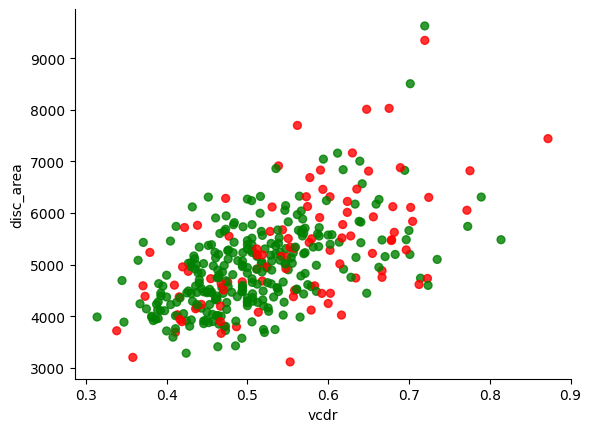

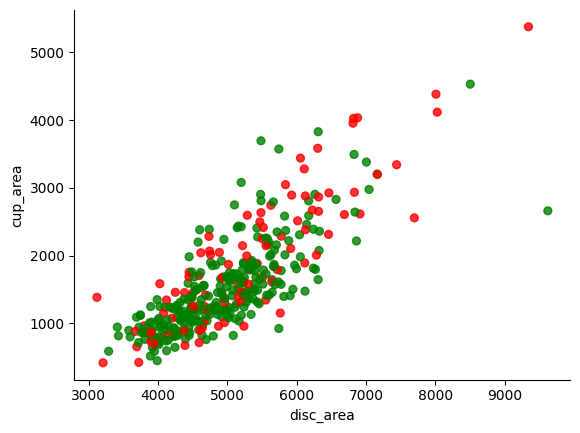

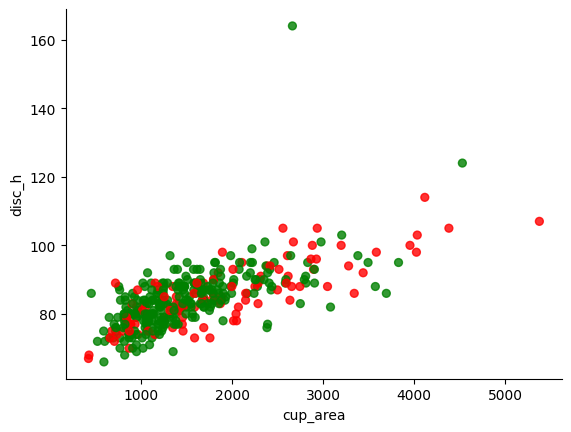

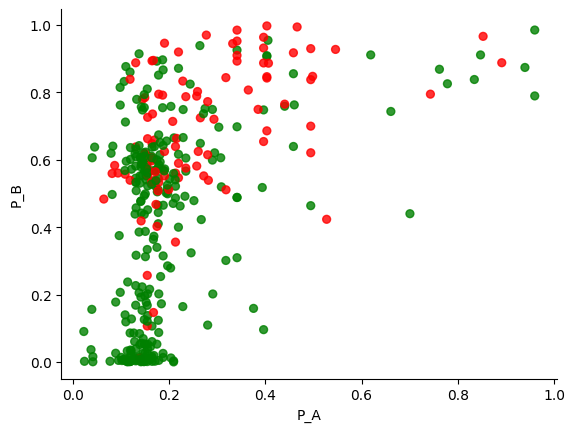

In [294]:
plotting(test_df)

#### Scatter plots overview (green = glaucoma 0, red = glaucoma 1)

- **vcdr vs disc_area**  
  Shows a moderate positive trend: higher *vcdr* generally corresponds to larger *disc_area*. The two classes overlap heavily, with a few high-value outliers.

- **disc_area vs cup_area**  
  Displays a strong positive relationship: as *disc_area* increases, *cup_area* also increases (nearly linear). Red points appear slightly more spread at higher values, but there is still substantial overlap.

- **cup_area vs disc_h**  
  Indicates a positive association: larger *cup_area* tends to align with higher *disc_h*. Most points cluster in the mid-range, with a few noticeable outliers.

- **P_A vs P_B**  
  Appears more clustered and less linear than the anatomical feature plots. Many samples gather at low *P_A* (~0.1–0.2) while *P_B* spans a wide range (including many near 0). Class separation is not clearly distinct in this 2D view.


## Glaucoma Prediction Pipeline (Segmentation + Feature Extraction + Image Classifier + Meta Fusion)

This cell builds an end-to-end glaucoma screening pipeline using four models:

- **Segmentation model (U-Net ResNet34)**: Loads a trained U-Net to segment the **optic disc** and **optic cup** from a fundus image. The masks are thresholded and used to compute structural measurements.
- **Structure-based classifier (P_A)**: Extracts five structural features — **VCDR**, **disc area**, **cup area**, **disc height**, and **cup height** — and feeds them into a calibrated XGBoost model to produce a probability **P_A**.
- **Image-based classifier (P_B)**: Loads an EfficientNet-B0 binary classifier that predicts glaucoma probability **directly from the image**, producing **P_B**.
- **Meta fusion model**: Combines **P_A** and **P_B** into a final probability using a calibrated fusion model, then applies a stored threshold (`meta_thr`) to output the final label (**Glaucoma** or **Normal**).

Key steps include image preprocessing for segmentation and classification, feature extraction from predicted masks, and final decision-making based on the fusion probability.


In [338]:
import torch
import numpy as np
import joblib
from PIL import Image
import segmentation_models_pytorch as smp
from torchvision import transforms, models
import torch.nn as nn
import os
import pandas as pd

# -----------------------
# GLOBAL CONFIG
# -----------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 384
SEG_SIZE = 512
THRESHOLD = 0.1   # screening threshold

# -----------------------
# LOAD MODELS (ONCE)
# -----------------------

# 1  Segmentation model
seg_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=2,
    activation=None
).to(DEVICE)

seg_model.load_state_dict(
    torch.load("best_unet_resnet34.pth", map_location=DEVICE)
)
seg_model.eval()

# 2  Structure-based classifier (P_A)
struct_model = joblib.load("xgb_glaucoma_calibrated.pkl")

# 3  Image classifier (P_B)
img_model = models.efficientnet_b0(weights=None)
img_model.classifier[1] = nn.Linear(
    img_model.classifier[1].in_features, 1
)
img_model.load_state_dict(
    torch.load("best_image_classifier.pth", map_location=DEVICE)
)
img_model = img_model.to(DEVICE)
img_model.eval()

# 4  Meta fusion model
meta_model = joblib.load("/content/model4_xgb_calibrated.joblib")
meta_info  = joblib.load("/content/model4_meta_info.joblib")
meta_thr = meta_info["thr"]

# -----------------------
# TRANSFORMS
# -----------------------
img_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# -----------------------
# HELPER FUNCTIONS
# -----------------------
def preprocess_seg_image(img_path):
    img = Image.open(img_path).convert("RGB").resize((SEG_SIZE, SEG_SIZE))
    x = np.array(img).astype(np.float32) / 255.0
    x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0)
    return x.to(DEVICE)

def vertical_diameter(mask):
    rows = np.where(mask.sum(axis=1) > 0)[0]
    return float(rows[-1] - rows[0] + 1) if len(rows) > 0 else 0.0

@torch.no_grad()
def extract_struct_features(img_path):
    x = preprocess_seg_image(img_path)
    logits = seg_model(x)
    prob = torch.sigmoid(logits)[0].cpu().numpy()

    disc = (prob[0] >= 0.5).astype(np.uint8)
    cup  = (prob[1] >= 0.5).astype(np.uint8)
    cup = cup * disc

    disc_area = disc.sum()
    cup_area  = cup.sum()

    disc_h = vertical_diameter(disc)
    cup_h  = vertical_diameter(cup)

    vcdr = cup_h / (disc_h + 1e-9)

    # Return only the 5 features expected by struct_model
    return np.array(
        [vcdr, float(disc_area), float(cup_area), disc_h, cup_h],
        dtype=np.float32
    )

@torch.no_grad()
def predict_image_prob(img_path):
    img = Image.open(img_path).convert("RGB")
    x = img_tfms(img).unsqueeze(0).to(DEVICE)
    logit = img_model(x).squeeze(1)
    return float(torch.sigmoid(logit).item())

# -----------------------
# FINAL PIPELINE FUNCTION
# -----------------------
def predict_glaucoma(img_path: str):
    """
    Input: image path (str)
    Output: dict with probabilities and final label
    """

    # P_A: structure-based probability
    feats = extract_struct_features(img_path)
    P_A = float(struct_model.predict_proba(feats.reshape(1, -1))[0, 1])

    # P_B: image-based probability
    P_B = predict_image_prob(img_path)

    # Final fusion
    X_meta = np.array([[P_A, P_B]], dtype=np.float32)
    P_final = float(meta_model.predict_proba(X_meta)[0, 1])

    label = "Glaucoma" if P_final >= meta_thr else "Normal"

    print(f'Prediction : {label}')




Examle Image

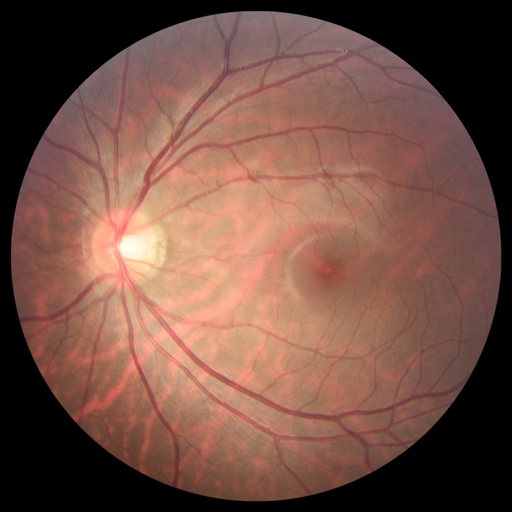


Prediction : Normal






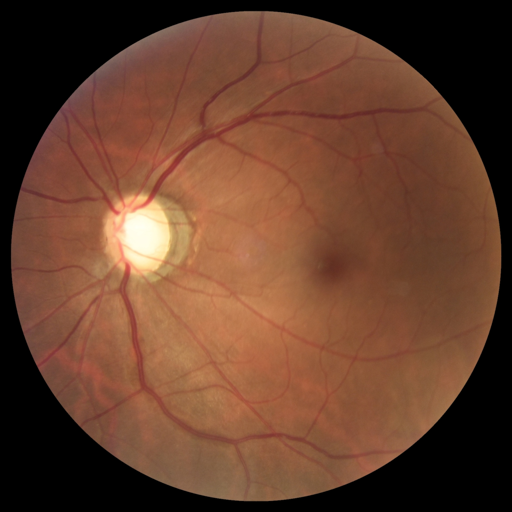


Prediction : Glaucoma


In [350]:
from PIL import Image
img1_path = "/kaggle/input/glaucoma-datasets/REFUGE/test/Images/T0100.jpg"
img2_path = "/kaggle/input/glaucoma-datasets/REFUGE/test/Images/T0010.jpg"

display(Image.open(img1_path).resize((512,512)))
print()
predict_glaucoma(img1_path)

print("\n\n\n")

display(Image.open(img2_path).resize((512,512)))
print()
predict_glaucoma(img2_path)

Save the Dataframes as a csv files

In [351]:
train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

This is prototype model only from Eye - Clinic.